In [30]:
import os
import pathlib
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import models

In [31]:
DATASET_PATH = 'speech'

data_dir = pathlib.Path(DATASET_PATH)

In [32]:
train_ds, val_ds = tf.keras.utils.audio_dataset_from_directory(
    directory=data_dir,
    batch_size=64,
    validation_split=0.2,
    seed=0,
    output_sequence_length=16000,
    subset='both'
)

label_names = np.array(train_ds.class_names)
print('Label names', label_names)

Found 16471 files belonging to 7 classes.
Using 13177 files for training.
Using 3294 files for validation.
Label names ['down' 'left' 'off' 'on' 'right' 'stop' 'up']


In [33]:
for audio, label in train_ds.take(1):
    print('Audio shape', audio.shape)
    print('Labels', label)

Audio shape (64, 16000, 1)
Labels tf.Tensor(
[6 6 1 6 2 6 6 0 3 3 0 0 1 5 0 1 0 1 3 0 4 1 1 4 3 1 1 2 0 5 3 6 5 0 3 0 5
 5 4 0 1 5 1 0 3 1 4 2 4 3 0 4 3 1 3 5 2 3 4 6 0 0 3 5], shape=(64,), dtype=int32)


In [34]:
def squeeze(audio, label):
    audio = tf.squeeze(audio, axis=-1)
    return audio, label

train_ds = train_ds.map(
    map_func=squeeze,
    num_parallel_calls=tf.data.AUTOTUNE
)

val_ds = val_ds.map(
    map_func=squeeze,
    num_parallel_calls=tf.data.AUTOTUNE
)

In [35]:
# 80% train, 10% test, 10% validation

test_ds = val_ds.shard(num_shards=2, index=0)
val_ds = val_ds.shard(num_shards=2, index=1)

In [36]:
for audio, label in train_ds.take(1):
    spectrogram = tf.signal.stft(audio, frame_length=255, frame_step=128)
    spectrogram = tf.abs(spectrogram)
    spectrogram = spectrogram[..., tf.newaxis]
    print(spectrogram.shape)

(64, 124, 129, 1)


In [37]:
def get_spectrogram(audio):
    spectrogram = tf.signal.stft(audio, frame_length=255, frame_step=128)
    spectrogram = tf.abs(spectrogram)
    spectrogram = spectrogram[..., tf.newaxis]
    return spectrogram

In [38]:
def make_spec_ds(ds):
    return ds.map(
        map_func=lambda audio, label: (get_spectrogram(audio), label),
        num_parallel_calls=tf.data.AUTOTUNE
    )

In [39]:
train_spec = make_spec_ds(train_ds)
test_spec = make_spec_ds(test_ds)
val_spec = make_spec_ds(val_ds)

In [40]:
# Caching

train_spec = train_spec.cache().shuffle(10000).prefetch(tf.data.AUTOTUNE)
test_spec = test_spec.cache().prefetch(tf.data.AUTOTUNE)
val_spec = val_spec.cache().prefetch(tf.data.AUTOTUNE)

In [41]:
for sample_spec, sample_label in train_spec.take(1):
    break

In [42]:
input_shape = sample_spec.shape[1:]
num_labels = len(label_names)

# Normalization Layer
norm_layer = layers.Normalization()
norm_layer.adapt(
    data=train_spec.map(
        map_func=lambda spec, label: spec
    )
)

# CNN Model Architecture
model = models.Sequential(
    [
        layers.Input(input_shape),
        layers.Resizing(32, 32),
        norm_layer,
        layers.Conv2D(32, 3, activation='relu'),
        layers.Conv2D(64, 3, activation='relu'),
        layers.MaxPooling2D(),
        layers.Dropout(0.2),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(num_labels)
    ]
)

In [43]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resizing_1 (Resizing)           │ (None, 32, 32, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ normalization_1 (Normalization) │ (None, 32, 32, 1)      │             3 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 30, 30, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 28, 28, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │     1,605,760 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 7)              │           903 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,625,482 (6.20 MB)

 Trainable params: 1,625,479 (6.20 MB)

 Non-trainable params: 3 (16.00 B)

In [44]:
model.compile(
    metrics=['accuracy'],
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=tf.keras.optimizers.Adam()
)

In [45]:
history = model.fit(
    train_spec,
    validation_data=val_spec,
    epochs=10,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=2)
)

Epoch 1/10
206/206 ━━━━━━━━━━━━━━━━━━━━ 13s 53ms/step - accuracy: 0.4229 - loss: 1.5845 - val_accuracy: 0.8141 - val_loss: 0.6442
Epoch 2/10
206/206 ━━━━━━━━━━━━━━━━━━━━ 10s 47ms/step - accuracy: 0.7664 - loss: 0.7189 - val_accuracy: 0.8583 - val_loss: 0.4509
Epoch 3/10
206/206 ━━━━━━━━━━━━━━━━━━━━ 10s 48ms/step - accuracy: 0.8462 - loss: 0.4729 - val_accuracy: 0.8877 - val_loss: 0.3612
Epoch 4/10
206/206 ━━━━━━━━━━━━━━━━━━━━ 10s 50ms/step - accuracy: 0.8736 - loss: 0.3763 - val_accuracy: 0.9000 - val_loss: 0.3084
Epoch 5/10
206/206 ━━━━━━━━━━━━━━━━━━━━ 10s 49ms/step - accuracy: 0.8966 - loss: 0.3142 - val_accuracy: 0.9012 - val_loss: 0.2933
Epoch 6/10
206/206 ━━━━━━━━━━━━━━━━━━━━ 10s 49ms/step - accuracy: 0.9089 - loss: 0.2741 - val_accuracy: 0.9110 - val_loss: 0.2682
Epoch 7/10
206/206 ━━━━━━━━━━━━━━━━━━━━ 10s 50ms/step - accuracy: 0.9174 - loss: 0.2459 - val_accuracy: 0.9135 - val_loss: 0.2566
Epoch 8/10
206/206 ━━━━━━━━━━━━━━━━━━━━ 10s 49ms/step - accuracy: 0.9241 - loss: 0.2321 - 

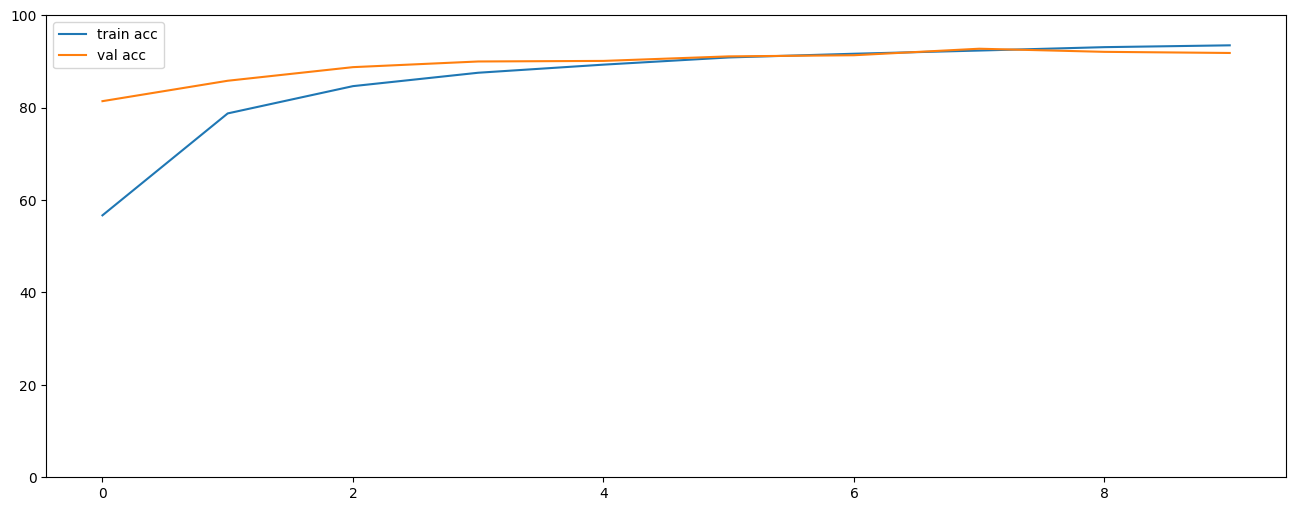

In [46]:
metrics = history.history

plt.figure(figsize=(16, 6))
plt.plot(history.epoch, 100*np.array(metrics['accuracy']), 100*np.array(metrics['val_accuracy']))
plt.legend(['train acc', 'val acc'])
plt.ylim([0, 100])
plt.show()

In [47]:
y_pred = model.predict(test_spec)
y_pred = tf.argmax(y_pred, axis=1)

print(y_pred)

26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step
tf.Tensor([5 0 6 ... 4 4 3], shape=(1664,), dtype=int64)


In [48]:
def convert_label(indexes):
    return [label_names[index.numpy()] for index in indexes]

y_pred = convert_label(y_pred)
y_true = convert_label(tf.concat([label for _, label in test_spec], axis=0))

for index, (label_pred, label_true) in enumerate(zip(y_pred, y_true)):
    print('Pred:', label_pred, '| True:', label_true)

Pred: stop | True: stop
Pred: down | True: down
Pred: up | True: up
Pred: right | True: right
Pred: stop | True: stop
Pred: off | True: off
Pred: stop | True: stop
Pred: stop | True: down
Pred: on | True: on
Pred: left | True: left
Pred: up | True: up
Pred: down | True: down
Pred: down | True: down
Pred: on | True: on
Pred: up | True: up
Pred: up | True: up
Pred: down | True: down
Pred: on | True: on
Pred: off | True: off
Pred: stop | True: stop
Pred: up | True: up
Pred: up | True: up
Pred: on | True: on
Pred: on | True: on
Pred: off | True: off
Pred: stop | True: stop
Pred: right | True: right
Pred: on | True: on
Pred: up | True: up
Pred: up | True: off
Pred: on | True: on
Pred: up | True: up
Pred: off | True: off
Pred: stop | True: stop
Pred: on | True: off
Pred: down | True: down
Pred: off | True: off
Pred: down | True: down
Pred: down | True: down
Pred: stop | True: stop
Pred: stop | True: stop
Pred: on | True: on
Pred: down | True: down
Pred: left | True: left
Pred: stop | True: s

In [50]:
y_pred = np.array(y_pred)
y_true = np.array(y_true)

acc = np.mean(y_pred == y_true)
print('Accuracy =', acc*100, '%')

Accuracy = 90.26442307692307 %
